In [1]:
import rospy
from sensor_msgs.msg import CompressedImage, Image
from geometry_msgs.msg import Twist
from cv_bridge import CvBridge
import cv2
import numpy as np
from IPython.display import display, clear_output
from PIL import Image as PILImage


In [2]:
class BlueTrackerNode:
    def __init__(self,
                 image_topic_in="/camera/color/image_raw/compressed",
                 image_topic_out="/camera/color/image_processed",
                 cmd_topic="/cmd_vel/auto"):

        # Jupyter에서 여러 번 실행될 수 있으니, 아직 초기화 안 됐으면 여기서 초기화
        if not rospy.core.is_initialized():
            rospy.init_node('jupyter_blue_tracker', anonymous=True)

        self.bridge = CvBridge()

        # ====== 설정 ======
        self.image_topic_in  = image_topic_in    # 입력 카메라 토픽 (compressed)
        self.image_topic_out = image_topic_out   # 처리된 영상 출력 토픽
        self.cmd_topic       = cmd_topic         # 주행 명령 토픽

        # 파란색 HSV 범위 (필요하면 나중에 튜닝)
        self.blue_lower = np.array([100, 100, 50])
        self.blue_upper = np.array([140, 255, 255])

        # 제어 파라미터
        self.kp_angular  = 0.003   # 좌우 회전 gain (오차 픽셀당 rad/s)
        self.base_linear = 0.15    # 기본 전진 속도
        self.min_area    = 500     # 너무 작은 파란 물체는 무시
        self.stop_area   = 20000   # 이 이상 크면 너무 가까운 것으로 보고 멈춤
        # ==================

        # 퍼블리셔 & 서브스크라이버
        self.cmd_pub = rospy.Publisher(self.cmd_topic, Twist, queue_size=1)
        self.img_pub = rospy.Publisher(self.image_topic_out, Image, queue_size=1)

        # 입력은 CompressedImage로 구독
        self.sub = rospy.Subscriber(
            self.image_topic_in,
            CompressedImage,
            self.image_callback,
            queue_size=1
        )

    def image_callback(self, msg: CompressedImage):
        # CompressedImage → OpenCV BGR
        np_arr = np.frombuffer(msg.data, np.uint8)
        frame = cv2.imdecode(np_arr, cv2.IMREAD_COLOR)
        if frame is None:
            return

        h, w, _ = frame.shape
        center_x = w // 2

        # BGR → HSV
        hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

        # 파란색 영역 마스크
        mask = cv2.inRange(hsv, self.blue_lower, self.blue_upper)
        # 노이즈 제거
        mask = cv2.erode(mask, None, iterations=2)
        mask = cv2.dilate(mask, None, iterations=2)

        # 윤곽선 찾기
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        twist = Twist()

        if contours:
            c = max(contours, key=cv2.contourArea)
            area = cv2.contourArea(c)

            if area > self.min_area:
                x, y, w_box, h_box = cv2.boundingRect(c)
                cx = x + w_box // 2
                cy = y + h_box // 2

                # 화면 중앙과 파란색 중심의 오차 (왼쪽이면 +, 오른쪽이면 -)
                error_x = center_x - cx

                # 좌우 회전
                twist.angular.z = self.kp_angular * error_x

                # 거리(면적)에 따라 전진/정지
                if area < self.stop_area:
                    twist.linear.x = self.base_linear
                else:
                    twist.linear.x = 0.0

                # 디버그용 표시
                cv2.rectangle(frame, (x, y), (x + w_box, y + h_box), (255, 0, 0), 2)
                cv2.circle(frame, (cx, cy), 5, (0, 0, 255), -1)
                cv2.line(frame, (center_x, 0), (center_x, h), (0, 255, 0), 1)
                cv2.putText(frame, f"Area: {int(area)}", (x, y - 10),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 0), 2)
            else:
                # 파란 물체가 너무 작으면 정지
                twist.linear.x = 0.0
                twist.angular.z = 0.0
        else:
            # 파란색이 안 보이면 정지
            twist.linear.x = 0.0
            twist.angular.z = 0.0

        # 명령 퍼블리시
        self.cmd_pub.publish(twist)

        # 처리된 이미지를 /camera/color/image_processed 로 퍼블리시
        out_msg = self.bridge.cv2_to_imgmsg(frame, encoding='bgr8')
        self.img_pub.publish(out_msg)

        # === OpenCV 창 출력 ===
        cv2.imshow("Blue Tracking - Debug", frame)
        cv2.imshow("Blue Mask", mask)
        cv2.waitKey(1)

        # === Jupyter 출력 ===
        rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        pil_img = PILImage.fromarray(rgb)
        clear_output(wait=True)
        display(pil_img)


In [3]:
blue_tracker = BlueTrackerNode()

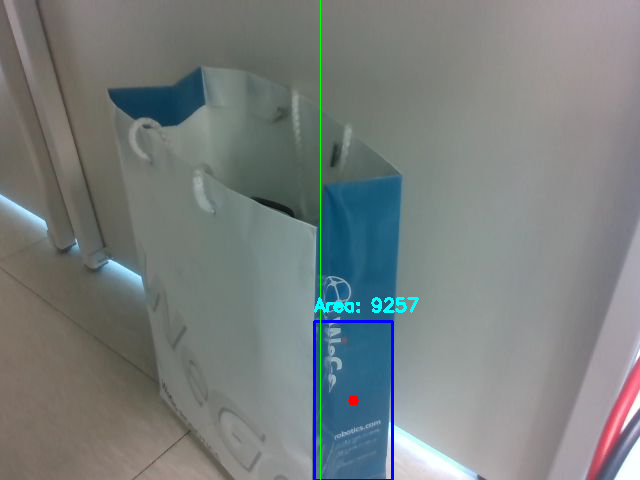

In [ ]:
rate = rospy.Rate(10)

while not rospy.is_shutdown():
    rate.sleep()

cv2.destroyAllWindows()
